<a href="https://colab.research.google.com/github/TurkuNLP/register-DeepL/blob/main/register_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this notebook put the file in the directory.

In [1]:
!wget -nc https://github.com/TurkuNLP/register-DeepL/blob/main/AfterDeepL/es_FINAL.tsv.gz # the repo is private so this does not work lol

File ‘es_FINAL.tsv.gz’ already there; not retrieving.



In [2]:
!pip3 install -q transformers datasets

In [3]:
import transformers
import datasets
import gzip 
import random
import re
import json
import torch

from pprint import PrettyPrinter
import logging
pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [4]:
file_name = "es_FINAL.tsv.gz"
data=[]
with gzip.open(file_name, 'rb') as f:
    for line in f:
        line = line.decode()
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=2: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

pprint(data[0])

['NA OP',
 "El martes por la noche, Sarah Palin se pasó por el programa de Bill O'Reilly "
 'para hablar de algunos comentarios recientes de Laura Ingraham, así como del '
 'enfoque que debería adoptar la candidatura de Romney/Ryan en la recta final '
 'de la campaña. Insistiendo en el argumento de que Mitt Romney debe ser más '
 'agresivo, Palin definió las elecciones como una elección entre "cosas gratis '
 'o libertad". Preguntada por el comentario de Ingraham de que si los '
 'republicanos no pueden ganar estas elecciones, deberían cerrar el partido, '
 'Palin también estuvo de acuerdo en que estas elecciones deberían favorecer a '
 'Romney. Rush Limbaugh dijo igualmente que la reelección del presidente '
 'señalaría el fin del GOP. La cuestión, dijo, es que el mensaje llegue a los '
 'votantes. "Si no puedes hacer llegar tu mensaje a través de ese filtro de '
 'los medios de comunicación, entonces estamos en un mundo de dolor", dijo. Lo '
 'que los republicanos no están haciendo, 

In [5]:
random.seed(1234) # remember to shuffle since the data is now in en,fi,swe,fre order
random.shuffle(data) 

In [6]:
# get a list of all the unique labels in the data using set which does not allow duplicates

labels = [one[0] for one in data]

#this splits all of the labels into their own thing for multilabeling
split_labels= []
for labeled in labels:
  labeleds = labeled.split()
  for label in labeleds:
    split_labels.append(label)
print(split_labels[:10])

labelset = set(split_labels) #split_labels
unique_labels=list(labelset)

# or make a label list from the picture which includes all the possibilities ? there should be 55 different but our dataset only has 43 which will do for now at least
# format of the labels? base+sub together in the label list?

texts= [one[1] for one in data]
print(len(unique_labels)) 
print(unique_labels[:10])

['DT', 'IN', 'IP', 'IN', 'HI', 'LT', 'IP', 'DS', 'MT', 'OS']
43
['CM', 'DF', 'PB', 'AV', 'QA', 'EN', 'FA', 'PO', 'OS', 'IG']


In [7]:
# split the labels into a list in the data
for i in range(len(data)):
  labeledlist = data[i][0]
  lablist = labeledlist.split()
  data[i][0] = lablist

print(data[0][0])

labels = [one[0] for one in data]
print(labels[:10])

['DT', 'IN']
[['DT', 'IN'], ['IP'], ['IN', 'HI', 'LT'], ['IP', 'DS'], ['MT', 'OS'], ['DT', 'IN'], ['IP'], ['HI'], ['IP', 'DS'], ['NA', 'IN']]


In [8]:
# indexlist = []
# line = []
# for i in range(len(data)):
#   lab = data[i][0]
#   for j in range(len(lab)):
#     line.append(unique_labels.index(lab[j]))
#   indexlist.append(line)
#   line= []
# print(indexlist[0])


# then one-hot encode all the labels in the data?
# I guess I could use pandas for this, first change everything to pandas format and then encode the labels

import pandas as pd

df = pd.DataFrame({
    "text": texts,
    "labels": labels
})
print(df)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
yt = mlb.fit_transform(df.labels)
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

ytlist= []
for labs in yt:
  ytlist.append(labs)


df = pd.DataFrame({
    "text": texts,
    "labels": ytlist
})

                                                   text            labels
0     Otro tipo de jueves y el curso Hacia una vida ...          [DT, IN]
1     Todavía quedan algunas plazas en la próxima se...              [IP]
2     Introduce tu dirección de correo electrónico y...      [IN, HI, LT]
3     - ASUPERMALL Bolsa de almacenamiento compatibl...          [IP, DS]
4     Categorías Negocio en casa Tengo que admitir q...          [MT, OS]
...                                                 ...               ...
9262  Páginas Nov 17, 2012 Cortando tu prosa dorada ...              [NA]
9263  Lyrics Depot es tu fuente de la letra de It Ha...              [LY]
9264  ¿Qué es la idea de contactar? ¿Cuál es la idea...              [ID]
9265  Mi hermano murió hace dos años Otras preguntas...              [ID]
9266  Esperamos darle la bienvenida al Mercure Wagga...  [IP, OP, DS, RV]

[9267 rows x 2 columns]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0

In [9]:
#print(df)
dataset = datasets.Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['text', 'labels'],
    num_rows: 9267
})


In [10]:
# with open("translated-register-data.jsonl", "wt") as f:
#     for cols, labs in zip(data, yt):
#         item = {
#             "text": cols[1],
#             "labels": labs.tolist() #labs #unique_labels.index(cols[0]),
#              # change this to have the binary one-hot encoded list of the labels, or a list of the labels => anyway a list
#         }
#         print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [11]:
# Dataset_ready = ""
# for label in unique_labels:
#   label = "\"" + label + "\""
#   Dataset_ready = Dataset_ready + label +": datasets.Value(\"int64\"), "

# pprint(Dataset_ready)

# # this makes the dataset ready to receive encoded data

In [12]:
# file = "translated-register-data.jsonl"
# dataset = datasets.load_dataset(
#     'json',                             
#     data_files={"everything":file}, # I need the test set from Veronika? ask Filip and Veronika
#     split={
#         "train":"everything[:80%]",  
#         "validation":"everything[80%:90%]",   
#         "test":"everything[90%:]"    
#     }#,
#     # features=datasets.Features({
#     #     "text":datasets.Value("string")   # glad I found out that this works even without the features specifically mentioned, huggingface documentation mentioned they were optional
#     # })
# )

#         # "labels":datasets.Sequence(datasets.ClassLabel(names=unique_labels)}), #datasets.ClassLabel(names=unique_labels), 
#         # # change this somehow to take all labels into account??? => datasets.Sequence(feature={}) that should include all the label features I want to give

# dataset     

In [13]:
dataset = dataset.train_test_split(test_size=0.2) # change name of test to dev and later append the test set here (change the labels like below )
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 7413
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1854
    })
})


In [14]:
print(dataset["train"][0])

{'text': 'No te preocupes. Entregamos a los minoristas de Postnord en toda Suecia. Para algunos códigos postales también ofrecemos la entrega exprés en su domicilio en un plazo de 4 horas. Vaya a la caja para ver las opciones que tiene.', 'labels': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [15]:
model_name = "xlm-roberta-base" # we use the xlmr for tokenizing (large)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True, # do something else other than truncating? the texts now have max 1024 tokens
    )

dataset = dataset.map(tokenize)

  0%|          | 0/7413 [00:00<?, ?ex/s]

  0%|          | 0/1854 [00:00<?, ?ex/s]

In [16]:
# cast label IDs to floats
#dataset.remove_columns("text")
dataset.reset_format()
print(dataset["train"].format)
dataset.set_format(type="pandas", columns=['labels', 'input_ids', 'attention_mask'])
print(dataset["train"].format)
#print(dataset["train"][0])
dataset.set_format(type="torch", columns=['labels', 'input_ids', 'attention_mask'])
print(dataset["train"].format)
dataset = dataset.map(lambda x : {"float_labels": x["labels"].to(torch.float32)}, remove_columns=["labels", "text"])
#dataset.remove_columns("labels")
print(dataset)
dataset = dataset.rename_column("float_labels", "labels")

{'type': None, 'format_kwargs': {}, 'columns': ['text', 'labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}
{'type': 'pandas', 'format_kwargs': {}, 'columns': ['labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}
{'type': 'torch', 'format_kwargs': {}, 'columns': ['labels', 'input_ids', 'attention_mask'], 'output_all_columns': False}


  0%|          | 0/7413 [00:00<?, ?ex/s]

  0%|          | 0/1854 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'float_labels'],
        num_rows: 7413
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'float_labels'],
        num_rows: 1854
    })
})


In [17]:
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(unique_labels), problem_type="multi_label_classification")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [18]:
# I should change these eventually to find the best hyperparameters

trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=0.00001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    max_steps=1500
)


In [24]:
# accuracy = datasets.load_metric("accuracy")

# def compute_accuracy(outputs_and_labels):
#     outputs, labels = outputs_and_labels
#     predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
#     return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)


# # for the actual multilabel thing we need to use another metric
# #microF1
# from sklearn.metrics import precision_recall_fscore_support
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions.argmax(-1)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro') # switch from binary to micro for multilabel at least
#   #  acc = accuracy_score(labels, preds)
#     return {
#    #     'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }
import numpy as np
from transformers import EvalPrediction
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.3):  # with 0.1 the spanish data is not doing great
    # the treshold has to be really low because the probabilities of the predictions are not great, could even do without any treshold then? or find one that works best between 0.1 and 0.5 (with english)
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels) # why is the sigmoid applies? could do without it
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    #next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [20]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [21]:
class MultilabelTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), 
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7413
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1854
    })
})

In [25]:
trainer = MultilabelTrainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
100,0.185400,0.162668,0.214259,0.574156,0.042071
200,0.161000,0.150821,0.214259,0.574156,0.042071
300,0.151600,0.146512,0.214259,0.574156,0.042071
400,0.146500,0.143824,0.213941,0.573098,0.041532
500,0.146800,0.142144,0.215894,0.574049,0.042071
600,0.145100,0.140247,0.207724,0.565089,0.039374
700,0.142900,0.137416,0.305122,0.612666,0.066343
800,0.141300,0.134947,0.325822,0.621661,0.063646
900,0.138400,0.133239,0.348962,0.634726,0.067422
1000,0.132700,0.131838,0.368237,0.646016,0.066882


TrainOutput(global_step=1500, training_loss=0.14352548535664877, metrics={'train_runtime': 2388.2874, 'train_samples_per_second': 5.025, 'train_steps_per_second': 0.628, 'total_flos': 3156467425925424.0, 'train_loss': 0.14352548535664877, 'epoch': 1.62})

In [28]:
eval_results = trainer.evaluate(dataset["test"])

print(eval_results)
# with eng downsampled the f1 ended up at 51%, with spanish at 40%

{'eval_loss': 0.1276398003101349, 'eval_f1': 0.40090090090090086, 'eval_roc_auc': 0.6613213215077482, 'eval_accuracy': 0.08737864077669903, 'eval_runtime': 67.2021, 'eval_samples_per_second': 27.588, 'eval_steps_per_second': 0.863, 'epoch': 1.62}


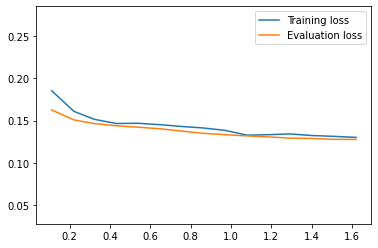

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

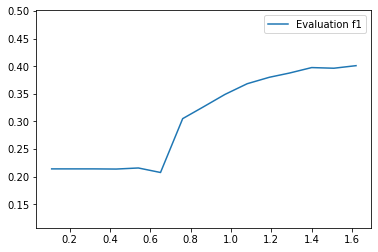

In [29]:
plot(training_logs.logs, ["eval_f1"], ["Evaluation f1"])

I think there are several reasons this does not work at all really:


1.   I am also truncating it to 512 and the original texts have 1024 tokens as agreed with filip to save space when translating texts -> another way to do this?
If I am truncating then it feels unnecessary to even have translated 1024 tokens but I guess more than 512 is needed although the beginning is apparently very telling when getting the register
2.   And for some registers (at least lyrical) the translations might not have been as good as hoped.

All in all, true multilabel is the only solution to this really and even then english data only having base labels might be an issue when the others have sublabels (this also depends on the target language test set and how the annotations are done)



It seems that whether I do multilabel or just multiclass the results stay relatively the same which is surprising to me (the results are always kind of shitty then). I guess it could have to do with the downsampling and the fact that the translation included different labeling tactics. BUT that shouldn't be a problem here (only with multiclass) since we use the binary in the multilabeling (except english still only has base labels which might have an effect).
For F1, Eng gets about 50% (starts from 40ish) and spanish gets 20ish THEN suddenly jumps to 30% and above and ends with 40% which is better than with multiclass!!!. Accuracy is similar for both (6%). 


I should test this on the spanish test set that Veronika has? https://github.com/TurkuNLP/SpaCORE
=> that one has different labeling at least sublabels are in lowercase so that has to be changed and the labels are also different from the picture that I have of the labelling????? ask Veronika



https://github.com/TurkuNLP/SimChiCORE
https://github.com/TurkuNLP/JpnCORE
Portuguese?



https://github.com/TurkuNLP/bert-for-core/blob/master/multilingual.md this could help me?